In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import seaborn as sns

In [14]:

model_predictions = np.load("results/pred_20251122_163129_best_val_1.0.npy")
ground_truths = np.load("results/ground_truths.npy")
model_samples = np.load("results/samples_20251122_163129_best_val_1.0.npy")
baseline_predictions = np.load("urbanev/TimeXer_predictions.npy")
baseline_predictions = np.concatenate([baseline_predictions[:, :, -1:], baseline_predictions], axis=-1)[:, :, :-1]
baseline_predictions = baseline_predictions[:model_predictions.shape[0]]
model_predictions = model_predictions[:baseline_predictions.shape[0]]
model_samples = model_samples[:baseline_predictions.shape[0]]


--- 概率预测评估脚本 ---

--- 正在计算 PIT 直方图 ---


C:\Users\ll\AppData\Local\Temp\ipykernel_30348\799534807.py:117: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_30348\799534807.py:117: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_30348\799534807.py:117: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_30348\799534807.py:117: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_30348\799534807.py:117: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_30348\799534807.py:117: UserWarning: Glyph 20540 (\N{CJK UNIFIED

PIT 直方图已保存到: pit_histogram.png

--- 正在计算可靠性图 ---
可靠性图已保存到: reliability_diagram.png


c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current fon

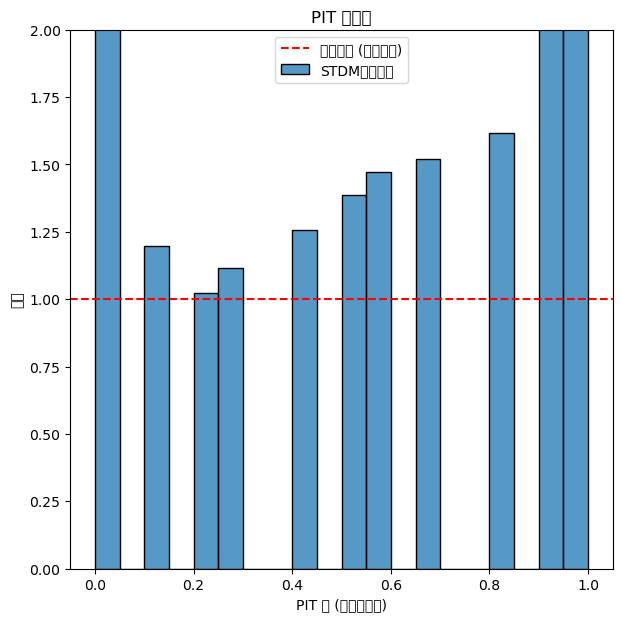

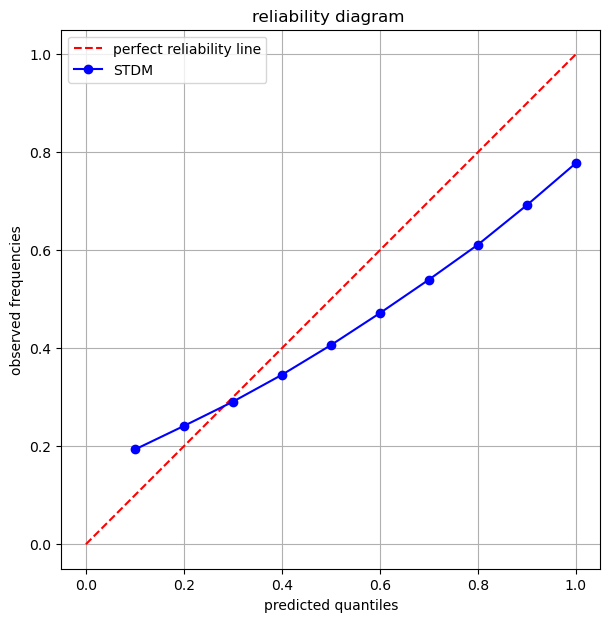

In [15]:
def calculate_pit(y_true, y_pred_samples):
    """
    计算概率积分变换 (PIT) 值。
    
    这是评估概率预测校准度的核心工具。
    它计算的是真实值 (y_true) 相对于预测样本 (y_pred_samples) 的经验分位数。
    
    参数:
    y_true (np.ndarray): 真实值数组。
                          形状: (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。
                                  形状: (B, S, L, N) 或 (num_datapoints, S)
                                  其中 S 是样本数量。

    返回:
    np.ndarray: 一维数组，包含所有数据点的 PIT 值 (范围在 0 到 1 之间)。
                如果预测完美校准，此数组应服从均匀分布。
    """
    
    # 为了进行广播比较，我们需要将 y_true 的形状扩展为 (B, 1, L, N)
    # 以便它能和 (B, S, L, N) 的 y_pred_samples 进行比较。
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        # 假设 y_true: (B, L, N), y_pred_samples: (B, S, L, N)
        # B = 批量大小, L = 预测长度, N = 节点数, S = 样本数
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (B, 1, L, N)
        sample_axis = 1 # 样本在 S 维度上
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        # 假设 y_true: (N,), y_pred_samples: (N, S)
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (N, 1)
        sample_axis = 1 # 样本在 S 维度上
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # (y_pred_samples <= y_true_expanded) 会生成一个布尔数组
    # np.mean(..., axis=sample_axis) 会计算布尔值为 True 的比例，
    # 这等同于 (count(samples <= true_value) / num_samples)
    pit_values = np.mean(y_pred_samples <= y_true_expanded, axis=sample_axis)
    
    # 返回所有 PIT 值的一维数组，以便绘制直方图
    return pit_values.flatten()

def calculate_reliability_diagram(y_true, y_pred_samples, num_bins=10):
    """
    计算可靠性图 (Reliability Diagram) 的数据点。

    参数:
    y_true (np.ndarray): 真实值数组。形状 (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。形状 (B, S, L, N) 或 (num_datapoints, S)
    num_bins (int): 要检查的分位数“箱子”的数量 (例如 10，将检查 0.1, 0.2, ..., 1.0)。

    返回:
    tuple: (expected_quantiles, observed_frequencies)
           - expected_quantiles (np.ndarray): 目标分位数 (例如 [0.1, 0.2, ..., 1.0])
           - observed_frequencies (np.ndarray): 真实值低于该预测分位数的实际频率
    """
    
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        sample_axis = 1
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        sample_axis = 1
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # 1. 定义我们想要检查的目标分位数（x轴）
    # 例如 num_bins=10, 结果为 [0.1, 0.2, ..., 1.0]
    expected_quantiles = np.linspace(0, 1, num_bins + 1)[1:]

    # 2. 从预测样本中计算这些分位数的“预测值”
    # q=expected_quantiles, axis=sample_axis
    # predicted_quantiles 的形状: (Q, B, L, N) 或 (Q, N)
    predicted_quantiles = np.quantile(y_pred_samples, q=expected_quantiles, axis=sample_axis)

    # 3. 检查真实值 (y_true) 在多大频率上低于这些“预测值”
    
    # (B, L, N) -> (1, B, L, N) 或 (N,) -> (1, N)
    y_true_expanded = np.expand_dims(y_true, axis=0) 
    
    # (y_true_expanded <= predicted_quantiles)
    # 广播比较 (1, B, L, N) <= (Q, B, L, N)
    # 结果 observed_booleans 形状为 (Q, B, L, N)
    observed_booleans = (y_true_expanded <= predicted_quantiles)
    
    # 沿着所有非分位数轴 (B, L, N) 计算均值，得到每个分位数的实际频率
    data_axes = tuple(range(1, y_true_expanded.ndim)) # (1, 2, 3) 或 (1,)
    observed_frequencies = np.mean(observed_booleans, axis=data_axes)
    
    return expected_quantiles, observed_frequencies


print("--- 概率预测评估脚本 ---")



# 定义数据形状
B = 500  # 批量大小 (数据点数量)
L = 12   # 预测长度
N = 275  # 节点数
S = 40   # 样本数 (NUM_SAMPLES)


# --- 2. 计算并绘制 PIT 直方图 ---
print("\n--- 正在计算 PIT 直方图 ---")
pit_values_calibrated = calculate_pit(ground_truths, model_samples)


plt.figure(figsize=(7, 7))
sns.histplot(pit_values_calibrated, bins=20, kde=False, stat="density", label="STDM模型分布")
plt.axhline(1.0, color='red', linestyle='--', label='完美校准 (均匀分布)')
plt.title('PIT 直方图')
plt.xlabel('PIT 值 (经验分位数)')
plt.ylabel('密度')
plt.legend()
plt.ylim(0, 2) # 设置Y轴范围以便比较


pit_hist_path = 'pit_histogram.png'
plt.savefig(pit_hist_path)
print(f"PIT 直方图已保存到: {pit_hist_path}")

# --- 3. 计算并绘制可靠性图 ---
print("\n--- 正在计算可靠性图 ---")
expected_q, observed_freq_calibrated = calculate_reliability_diagram(ground_truths, model_samples)

plt.figure(figsize=(7, 7))

plt.plot([0, 1], [0, 1], 'r--', label='perfect reliability line')
plt.plot(expected_q, observed_freq_calibrated, 'bo-', label='STDM')
plt.title('reliability diagram ')
plt.xlabel('predicted quantiles')
plt.ylabel('observed frequencies')
plt.axis('square') # 确保x和y轴等比例
plt.legend()
plt.grid(True)

reliability_diag_path = 'reliability_diagram.png'
plt.savefig(reliability_diag_path)
print(f"可靠性图已保存到: {reliability_diag_path}")